# Design Space Exploration with Draco

This Jupyter Notebook follows the comprehensive guide provided in [Draco's documentation](https://dig.cmu.edu/draco2/applications/design_space_exploration.html#).

In this notebook, we will explore the design space relevant to our specific context and datasets.


## Importing all necessary libraries

In [1]:
import json
import os
import draco
import altair as alt
from draco.renderer import AltairRenderer
from draco.debug import DracoDebug, DracoDebugChartConfig, DracoDebugPlotter
from app.services.temp_file_management import create_temp_file
from app.services.draco_service import get_draco_dataframe,get_draco_facts,get_draco_schema
import numpy as np
from IPython.display import Markdown, display
from tqdm import tqdm

### Display utilities

In [2]:
# Handles serialization of common numpy datatypes
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


def md(markdown: str):
    display(Markdown(markdown))


def pprint(obj):
    md(f"```json\n{json.dumps(obj, indent=2, cls=NpEncoder)}\n```")


## Special Notebook draco_rec_compute

Here we redefine draco_rec_compute so that we can use the display capacities of Jupyter Notebooks.

In [5]:

default_input_spec=[
    "entity(view,root,v0).",
    "entity(mark,v0,m0).",
]
def draco_rec_compute(data,specs:list[str]= default_input_spec,num_chart:int = 5, labeler=lambda i: f"CHART {i + 1}", Debug: bool=False):
    """
    Computes and recommends Draco charts based on the input data.

    Parameters:
    data (JSON): The raw input data to be processed.
    num_chart (int, optional): The number of charts to recommend. Default is 5.
    Debug(bool, optional):Debug mode, writes chart_specs_outpute to json files in ./data/events/temps/. Default is False.
    
    Returns:
    dict: A dictionary containing the recommended chart specifications and their renderings.
    """
    
    d = draco.Draco()
    renderer = AltairRenderer()
    draco_data=get_draco_dataframe(data)
    #print(draco_data)
    draco_facts=get_draco_facts(get_draco_schema(draco_data))
    input_spec_base = draco_facts + specs
    #print("\n\n\n///////////input_spec_base:\n",input_spec_base)
    if Debug:
        alt.renderers.enable("svg")

    
    def recommend_charts(
    spec: list[str], drc: draco.Draco, num: int = 2, labeler=lambda i: f"CHART {i + 1}"
):
        # Dictionary to store the generated recommendations, keyed by chart name
        chart_specs = {}
        
        for i, model in enumerate(drc.complete_spec(spec, num)):
            
            chart_name = labeler(i)
            schema = draco.answer_set_to_dict(model.answer_set)

            #print("draco spec",chart_specs[chart_name])
            #print(f"COST: {model.cost}")
            
            #computing vega lite spec for current recommendation
            chart_vega_lite = renderer.render(spec=schema, data=draco_data)
            if Debug:
                display(chart_vega_lite)
            chart_specs[chart_name] = draco.dict_to_facts(schema), schema
            #chart_specs[chart_name] = chart_vega_lite
            
            
        return chart_specs

    return recommend_charts(input_spec_base,d,num_chart)


Usage example :

Deleted temporary file: ./data/events/temps/3857257.json
Deleted temporary file: ./data/events/temps/CHART 1_output.vg.json
Deleted temporary file: ./data/events/temps/CHART 2_output.vg.json
Deleted temporary file: ./data/events/temps/CHART 3_output.vg.json
Deleted temporary file: ./data/events/temps/CHART 4_output.vg.json
Deleted temporary file: ./data/events/temps/CHART 5_output.vg.json
Temporary file created as a copy of the original file: ./data/events/temps/3857256.json


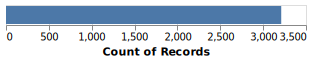

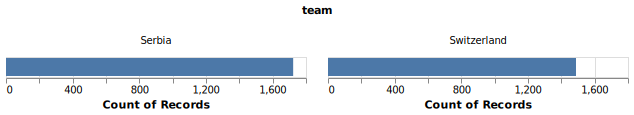

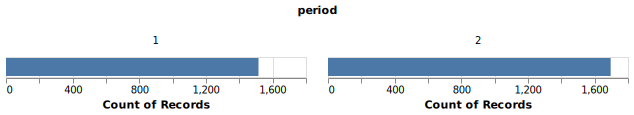

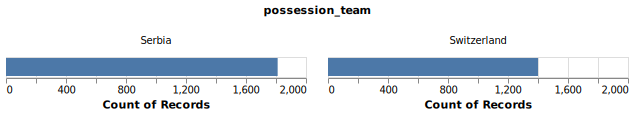

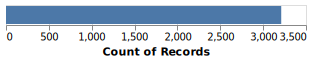

In [7]:
file_path = create_temp_file("3857256")
with open(file_path, 'r') as file:
    data = json.load(file)
    chart_specs=draco_rec_compute(data,Debug=True)

## Cleaning the dataset

The dataset contains certain fields that are disturbing the recommendation process just by there presence. For instance, *index* serves no real analytical purpose, yet *Draco* could output graphs with *index* as one of the main axis. 
Most importantly, *Draco* only handles dataframes with no empty cells. Since the events from the [datasets](https://github.com/statsbomb/open-data) don't all contains the same properties, converting the datasets into `pandas dataframe` will result in a lot of (mostly empty) columns that polute the recommendation given by *Draco*. Therefore, we need the data to be preprocessed before feeding it to the *Draco* pipeline.

The properties written in `vizreventServer\app\services\preprocessing_config.json` are kept are flattened to ease the formatting into `pandas dataframe`. All other properties are grouped in a new `payload` property. The processed dataset is then written in the `vizreventServer\data\events\temps` to still be able to access the rest of an event's data in case we need it later on.

Some of the recommendation created are not that interesting. And while cleaning the dataset did give us some promising evolution, it is not nearly enough.

Here are a few path to pursue to improve that: 
- ~~Currently, default values are equal to 0,"",() or [] according to the data field type. We could make it so that the default value still enables parsing (because clingo requires all cells in the dataframe to have a value) but that the recommendation process overlooks or filter rows(or events) with the default values. For example, for ints, the default value could be -1 or any negative value so that only positive value are displayed.~~
- Some data fields could be kept, but we add a hard constraint to not use them as a *primary* field, (e.g. period not being used in either axis but in the coloring or size or shape of the marks)
- The payloads could be accessed to give out more information in tooltips for instance, or perhaps when already working with some grouped data (e.g. when we are already using type="pass" events, we could also use the other properties linked to that).

*Note: The main assumption here is that the recommendation are mainly influenced by the constraints and that with well set constrains, we could keep all data fields. Therefore, we want to limit the removal of data field as little as possible. Thus, all results below are obtained with `vizreventServer/data/data_columns_to_remove.json` being:* 

## Inspecting the Knowledge Base

Similarly to the guide provided in the [Draco's documentation](https://dig.cmu.edu/draco2/applications/design_space_exploration.html#inspecting-the-knowledge-base), we use `DracoDebug` to investigate the recommendation provided by Draco.

In [8]:

def display_debug_data(draco: draco.Draco, specs: dict[str, tuple[list[str], dict]]):
    debugger = DracoDebug(
        specs={chart_name: fact_spec for chart_name, (fact_spec, _) in specs.items()},
        draco=draco,
    )
    chart_preferences = debugger.chart_preferences
    display(Markdown("**Raw debug data**"))
    display(chart_preferences.head())

    display(Markdown("**Number of violated preferences**"))
    num_violations = len(
        set(chart_preferences[chart_preferences["count"] != 0]["pref_name"])
    )
    num_all = len(set(chart_preferences["pref_name"]))
    display(
        Markdown(
            f"*{num_violations} preferences are violated out of a total of {num_all} preferences (soft constraints)*"
        )
    )

    display(
        Markdown(
            "Using `DracoDebugPlotter` to visualize the debug `DataFrame` produced by `DracoDebug`:"
        )
    )
    plotter = DracoDebugPlotter(chart_preferences)
    plot_size = (800, 200)
    chart = plotter.create_chart(
        cfg=DracoDebugChartConfig.SORT_BY_COUNT_SUM,
        violated_prefs_only=True,
        plot_size=plot_size,
    )
    chart.show()  # <-- If using Altair/VegaLite backend; else: export to HTML or save

**Raw debug data**

,chart_name,pref_name,pref_description,count,weight
0,CHART 1,cartesian_coordinate,Cartesian coordinates.,1,0
1,CHART 1,summary_bar,Bar mark for summary tasks.,1,0
2,CHART 1,aggregate_count,Count as aggregate op.,1,0
3,CHART 1,linear_x,Linear scale with x channel.,1,0
4,CHART 1,c_d_no_overlap_bar,Continuous by discrete for bar mark.,1,0


**Number of violated preferences**

*13 preferences are violated out of a total of 147 preferences (soft constraints)*

Using `DracoDebugPlotter` to visualize the debug `DataFrame` produced by `DracoDebug`:

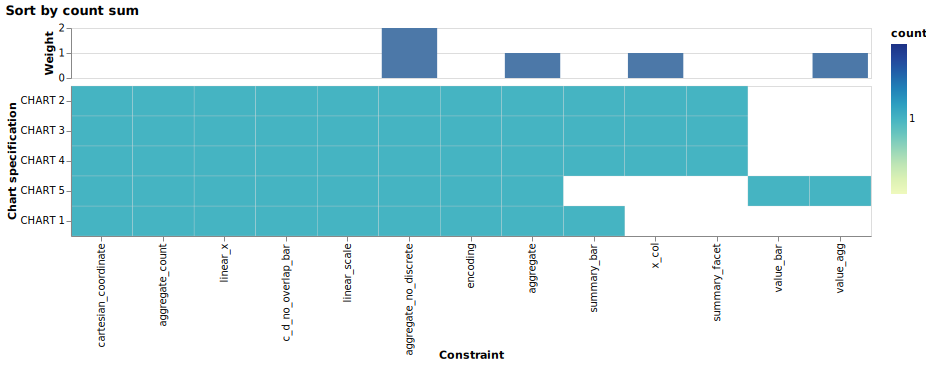

In [9]:
d = draco.Draco()
renderer = AltairRenderer()
alt.renderers.enable("svg")
display_debug_data(draco=d, specs=chart_specs)

## Generating Input Specifications Programmatically


Fetching the dataset and creating another, simple, partial specs:

In [18]:
test_specs = [
"entity(view,root,v).",
"attribute((view,coordinates),v,cartesian).",
"entity(mark,v,m).",
"entity(mark,v,m1).",

]
file_path = create_temp_file("3857256")
with open(file_path, 'r') as file:
    data = json.load(file)
    draco_data=get_draco_dataframe(data)
    draco_facts=get_draco_facts(get_draco_schema(draco_data))
    input_spec_base = draco_facts + test_specs

In [25]:
def rec_from_generated_spec(data,
    marks: list[str],
    fields: list[str],
    encoding_channels: list[str],
    draco: draco.Draco,
    num: int = 1,
) -> dict[str, dict]:
    input_specs = [
        (
            (mark, field, enc_ch),
            default_input_spec
            + [
                f"attribute((mark,type),m0,{mark}).",
                "entity(encoding,m0,e0).",
                f"attribute((encoding,field),e0,{field}).",
                f"attribute((encoding,channel),e0,{enc_ch}).",
                # filter out designs with less than 3 encodings
                ":- {entity(encoding,_,_)} < 3.",

            ],
        )
        for mark in marks
        for field in fields
        for enc_ch in encoding_channels
    ]
    #print(input_specs)
    recs = {}
    for cfg, spec in tqdm(input_specs, desc="Processing input specifications"):        
        def labeler(i):
            f"CHART {i + 1} ({' | '.join(cfg)})"
        recs = draco_rec_compute(data, specs=spec, num_chart=num, labeler=labeler,Debug=True)
        #print(recs)
    return recs

Processing input specifications:   0%|                                                                                          | 0/24 [00:00<?, ?it/s]

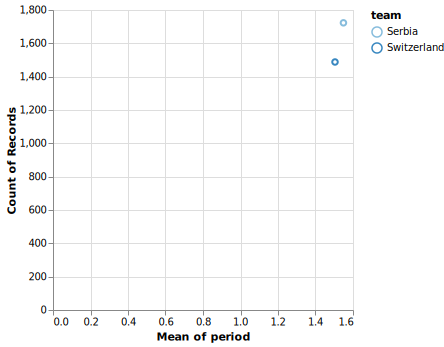

Processing input specifications:   4%|███▍                                                                              | 1/24 [00:00<00:08,  2.59it/s]

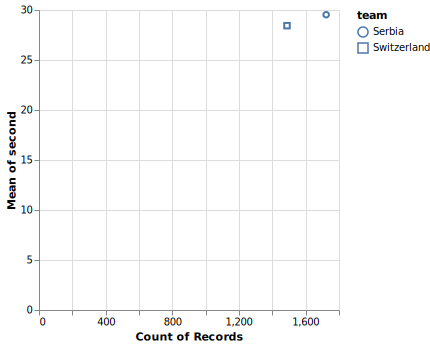

Processing input specifications:   8%|██████▊                                                                           | 2/24 [00:00<00:07,  2.87it/s]

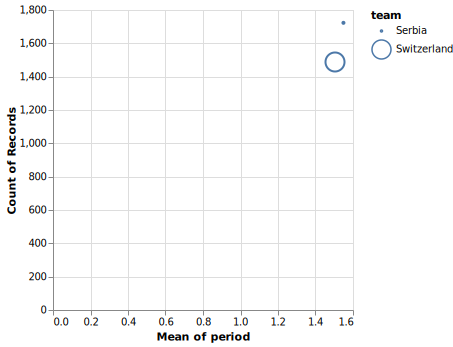

Processing input specifications:  12%|██████████▎                                                                       | 3/24 [00:01<00:07,  2.95it/s]

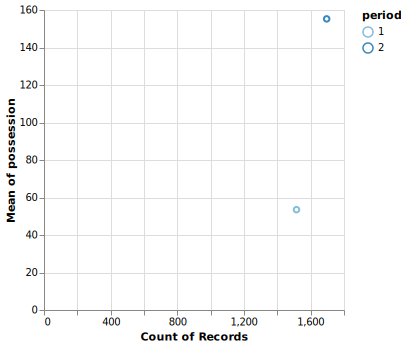

Processing input specifications:  17%|█████████████▋                                                                    | 4/24 [00:01<00:06,  2.99it/s]

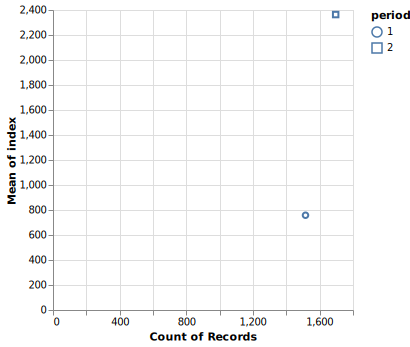

Processing input specifications:  21%|█████████████████                                                                 | 5/24 [00:01<00:06,  3.07it/s]

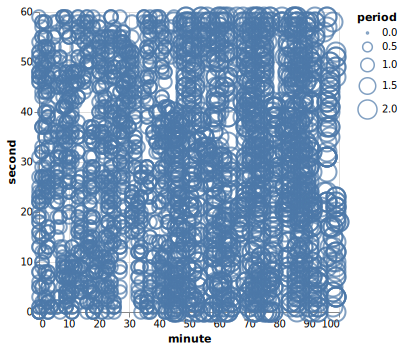

Processing input specifications:  25%|████████████████████▌                                                             | 6/24 [00:02<00:06,  2.82it/s]

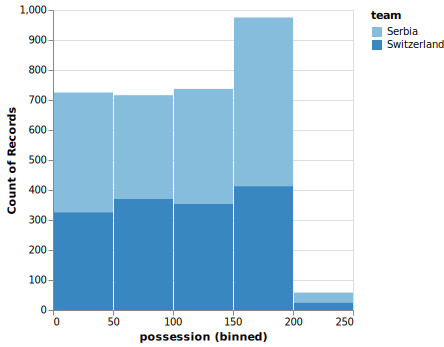

Processing input specifications:  38%|██████████████████████████████▊                                                   | 9/24 [00:02<00:04,  3.67it/s]

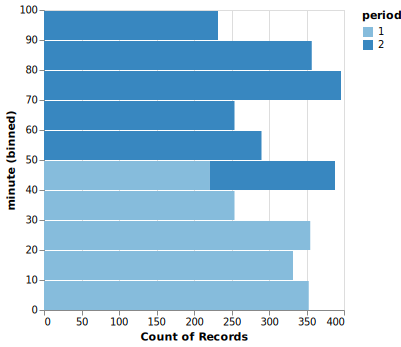

Processing input specifications:  50%|████████████████████████████████████████▌                                        | 12/24 [00:03<00:02,  4.23it/s]

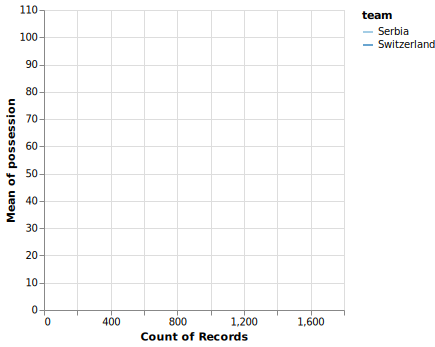

Processing input specifications:  62%|██████████████████████████████████████████████████▋                              | 15/24 [00:04<00:02,  4.37it/s]

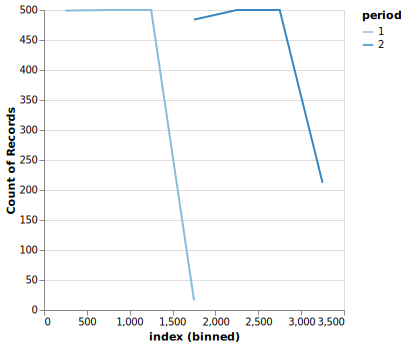

Processing input specifications:  75%|████████████████████████████████████████████████████████████▊                    | 18/24 [00:04<00:01,  4.75it/s]

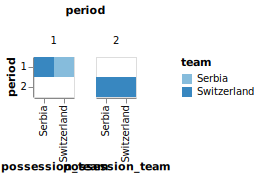

Processing input specifications:  88%|██████████████████████████████████████████████████████████████████████▉          | 21/24 [00:05<00:00,  4.47it/s]

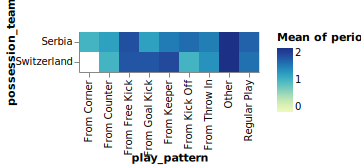

Processing input specifications: 100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.83it/s]


In [29]:
recommendations = rec_from_generated_spec(data,
        marks=["point", "bar", "line", "rect"],
        fields=["team", "period"],
        encoding_channels=["color", "shape", "size"],
        draco=d,num=1)

Checking constraint violation

**Raw debug data**

,chart_name,pref_name,pref_description,count,weight
0,CHART 1,cartesian_coordinate,Cartesian coordinates.,1,0
1,CHART 1,summary_bar,Bar mark for summary tasks.,1,0
2,CHART 1,aggregate_count,Count as aggregate op.,1,0
3,CHART 1,linear_x,Linear scale with x channel.,1,0
4,CHART 1,c_d_no_overlap_bar,Continuous by discrete for bar mark.,1,0


**Number of violated preferences**

*13 preferences are violated out of a total of 147 preferences (soft constraints)*

Using `DracoDebugPlotter` to visualize the debug `DataFrame` produced by `DracoDebug`:

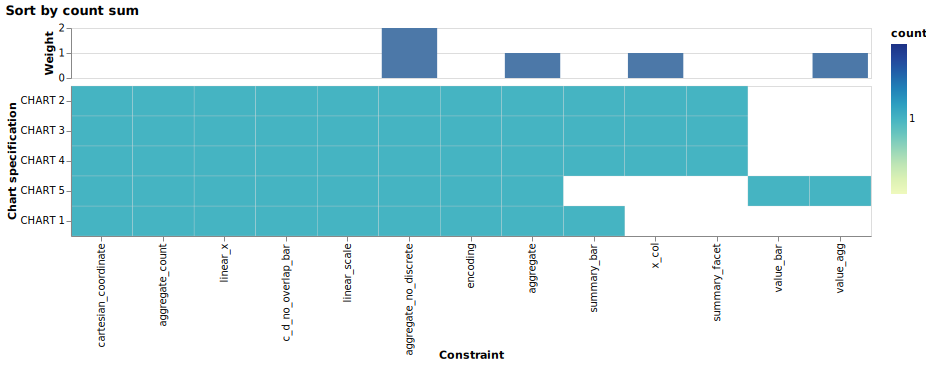

In [27]:
display_debug_data(draco=d, specs=chart_specs)

## Adjusting the Knowledge Base


Function to add new soft constraints to the Draco model.

In [ ]:
def draco_add_soft_constraint(drc: draco.Draco,
    new_constraints: list[tuple[str, int, str]]
) -> draco.Draco:
    """
    Update Draco with new soft constraints.

    Parameters:
    - new_constraints: List of tuples (constraint_name, weight, constraint_str)

    Returns:
    - draco.Draco object with updated soft program and weights
    """
    
    soft_updated = drc.soft
    weights_updated = drc.weights.copy()

    for name, weight, constraint_str in new_constraints:
        constraint_str = constraint_str.strip()
        # Prepend metadata comment
        annotated = f"% @soft({name})\n{constraint_str}"
        soft_updated += f"\n\n{annotated}"
        weights_updated[f"{name}_weight"] = weight

    return draco.Draco(soft=soft_updated, weights=weights_updated)


### Trying out new constraints

Generic constraints :

In [ ]:
# Soft constraints to guide better visualizations
constraints = [
    (
        "avoid_high_cardinality_color", 10,
        """
        preference(avoid_high_cardinality_color, E) :-
            entity(encoding, _, E),
            attribute((encoding,channel), E, color),
            attribute((encoding,field), E, F),
            attribute((field,type), F, string),
            attribute((field,unique), F, U), U > 20.
        """
    ),
    (
        "prefer_temporal_on_x", 8,
        """
        preference(prefer_temporal_on_x, E) :-
            entity(encoding, _, E),
            attribute((encoding,channel), E, x),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "timestamp").
        """
    ),
    (
        "avoid_id_in_encoding", 9,
        """
        preference(avoid_id_in_encoding, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "id").
        """
    ),
    (
        "prefer_high_std_on_y", 6,
        """
        preference(prefer_high_std_on_y, E) :-
            entity(encoding, _, E),
            attribute((encoding,channel), E, y),
            attribute((encoding,field), E, F),
            attribute((field,std), F, S), S > 5.
        """
    )
]

Trying to block irrelevant data fields such period, id, or possesion, to be considered:

In [ ]:
irrelevant_constraints = [
    (
        "avoid_id_field", 10,
        """
        preference(avoid_id_field, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "id").
        """
    ),
    (
        "avoid_index_field", 10,
        """
        preference(avoid_index_field, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "index").
        """
    ),
    (
        "avoid_timestamp_field", 10,
        """
        preference(avoid_timestamp_field, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "timestamp").
        """
    ),
    (
        "avoid_play_pattern_field", 7,
        """
        preference(avoid_play_pattern_field, E) :-
            entity(encoding, _, E),
            attribute((encoding,field), E, F),
            attribute((field,name), F, "play_pattern").
        """
    )
]

**Generating new Draco instance with these soft constraints**


In [ ]:
custom_draco = draco_add_soft_constraint(d,constraints)

Trying out the new constraints:

Processing input specifications:   0%|                                                                                           | 0/2 [00:00<?, ?it/s]

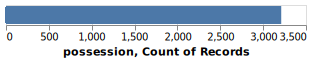

Processing input specifications:  50%|█████████████████████████████████████████▌                                         | 1/2 [00:00<00:00,  3.05it/s]

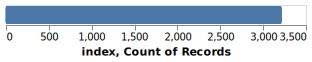

Processing input specifications: 100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.08it/s]


**Raw debug data**

,chart_name,pref_name,pref_description,count,weight
0,CHART 1,cartesian_coordinate,Cartesian coordinates.,1,0
1,CHART 1,summary_tick,Tick mark for summary tasks.,1,0
2,CHART 1,summary_bar,Bar mark for summary tasks.,1,0
3,CHART 1,aggregate_count,Count as aggregate op.,1,0
4,CHART 1,linear_x,Linear scale with x channel.,2,0


**Number of violated preferences**

*12 preferences are violated out of a total of 151 preferences (soft constraints)*

Using `DracoDebugPlotter` to visualize the debug `DataFrame` produced by `DracoDebug`:

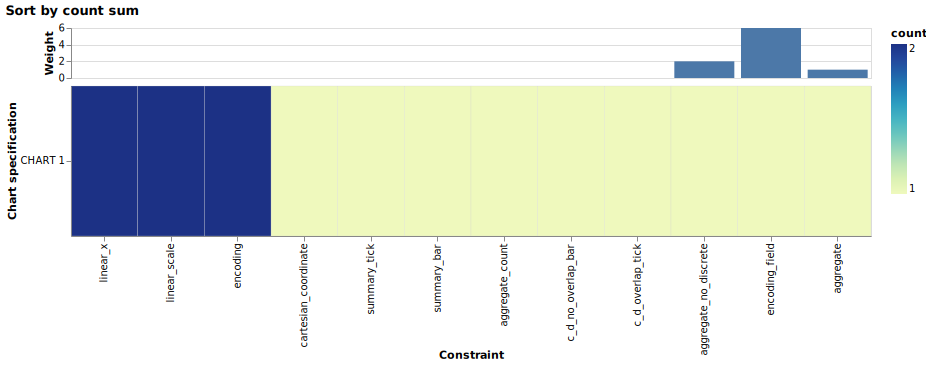

In [ ]:
recommendations = rec_from_generated_spec(data,
    marks=["rect"],
    fields=["timestamp", "id"],
    encoding_channels=["color"],
    draco=custom_draco,
)
display_debug_data(draco=custom_draco, specs=recommendations)
